# Facies classification from the 2016 SEG ML contest 

All the data, description is available [here](https://github.com/seg/2016-ml-contest).

This reproductio for the original SVM classification (Brendon Hall) and different classification used to see which method is better. I hope to beat the F1 score for the winner of the contest (0.6388).

Let's begin below!!

In [1]:
## importing libraries used by Brendon Hall
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

## Downloading the data

In [2]:
# # download .py file to use it
# r = requests.get('https://raw.githubusercontent.com/seg/2016-ml-contest/master/classification_utilities.py')  
# with open('/content/classification_utilities.py', 'wb') as f:
#     f.write(r.content)

In [3]:
# import the new libraries
from classification_utilities import display_cm, display_adj_cm

In [4]:
filename = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/training_data.csv'
training_data = pd.read_csv(filename)
training_data.head(3)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957


## Preparing the data

In [5]:
# Get the categorical variables
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
print(training_data['Well Name'].unique())
print(training_data['Formation'].unique())

['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (8, object): ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']
['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', ..., 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM']
Length: 14
Categories (14, object): ['A1 LM', 'A1 SH', 'B1 LM', 'B1 SH', ..., 'B5 LM', 'B5 SH', 'C LM', 'C SH']


## Exploratory data analysis 

Following the same code that Brendon Hall uses

In [6]:
# descriptive statistics of the continuos variables
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [7]:
# remove one well for a blind test later
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

In [8]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}

for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

training_data.loc[:,'FaciesLabels'] = (training_data
                                       .apply(lambda row: 
                                              label_facies(row, facies_labels), 
                                              axis=1))

In [9]:
# function to print well logs and facies (only works for variables in this dataset)

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

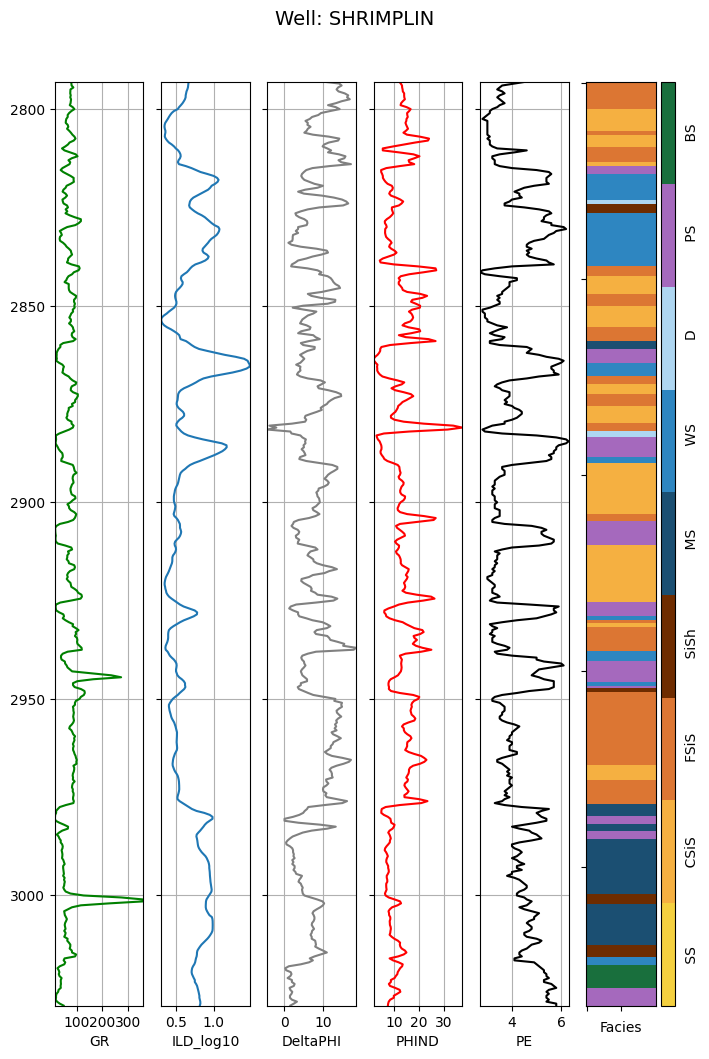

In [10]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: Facies, dtype: int64

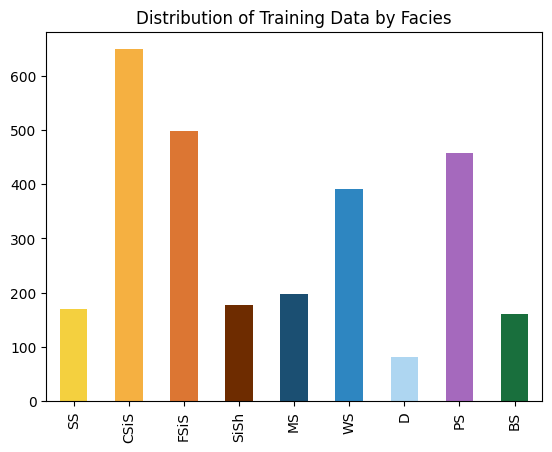

In [11]:
# distribution of the facies

facies_counts = training_data['Facies'].value_counts().sort_index()

facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

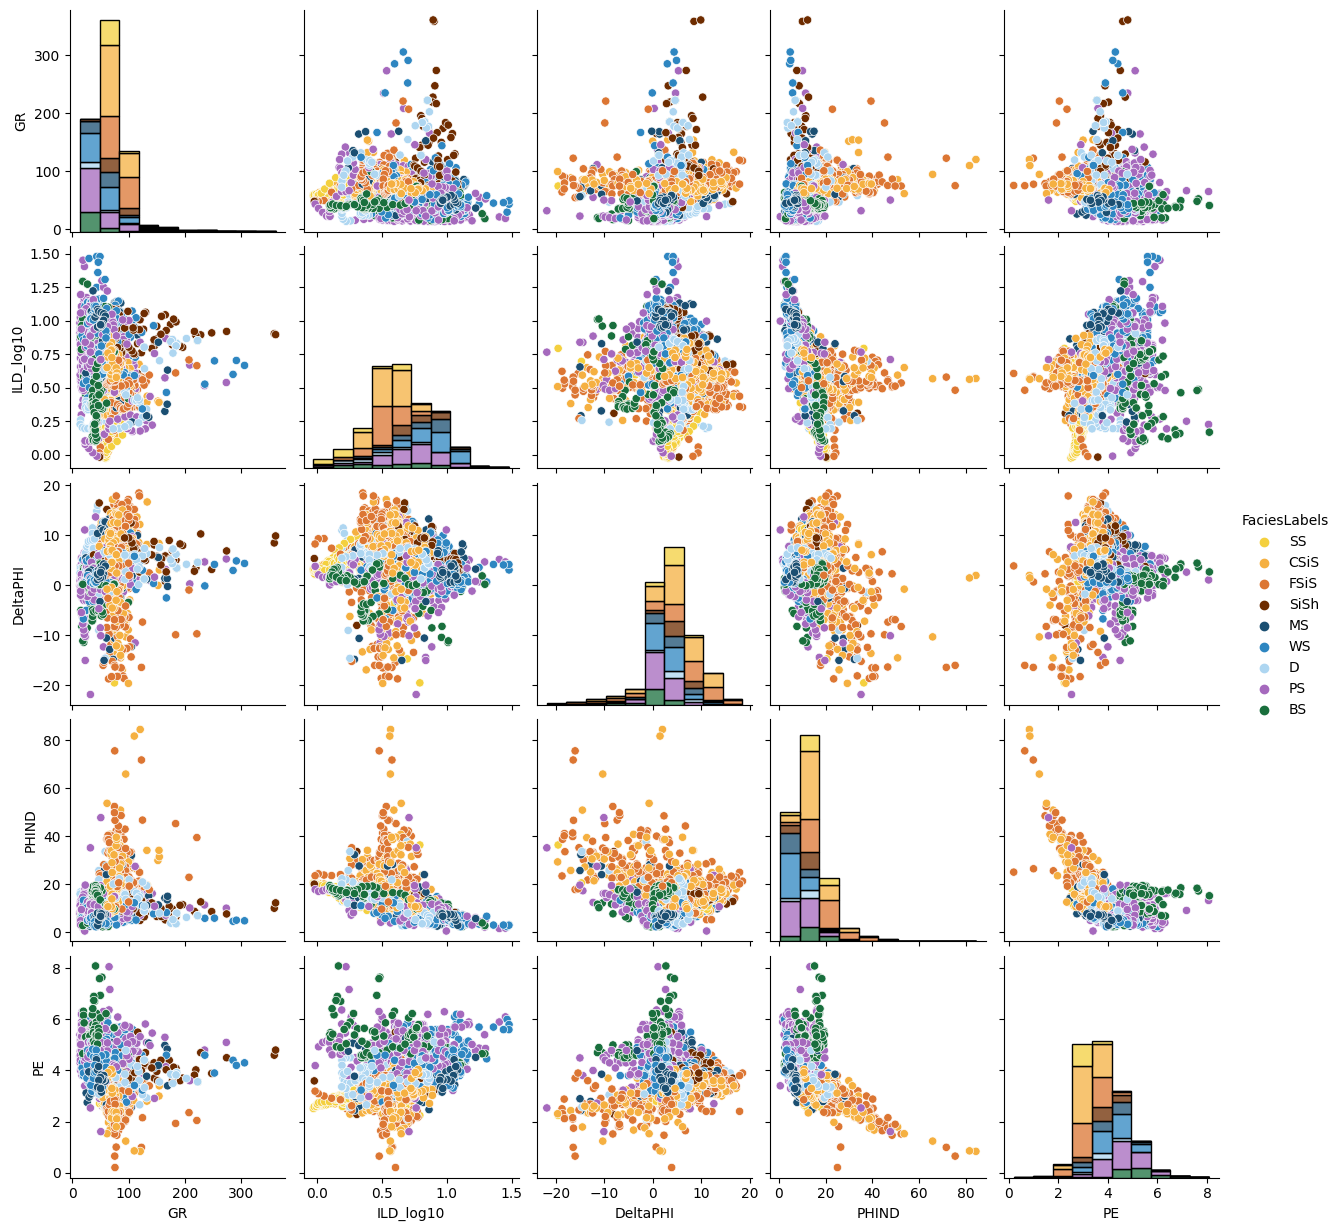

In [12]:
# pairplot
inline_rc = dict(mpl.rcParams)

sns.set_style(rc=inline_rc)
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
            #  hue_order=list(reversed(facies_labels)),
             hue_order=list(facies_labels),
             diag_kind='hist',
             diag_kws={'multiple': 'stack',
                       'bins':10})

In [13]:
# get only the values to the classification
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth',
                                      'Facies','FaciesLabels'], 
                                     axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


## Generating the train-test dataframes

In [49]:
from sklearn.impute import SimpleImputer

# Feture Imputation
def transform_data(df_with_data):
    scaler = (SimpleImputer(missing_values=np.nan, strategy='mean')
          .fit(df_with_data))
    X = scaler.transform(df_with_data)
    # standarization of the data (zero mean and unit variance, the "whitening")
    # scaler = preprocessing.StandardScaler().fit(feature_vectors)
    fetures_converted = preprocessing.StandardScaler().fit(X).transform(X)
    return fetures_converted

scaled_features = transform_data(feature_vectors)

In [15]:
# creating the train-test dataset 
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

## Support Vector Machine (SVM) classification solution!

We uses the Brendon Hall code for the SVM solution

In [16]:
clf = svm.SVC()

In [17]:
clf.fit(X_train,y_train)

SVC()

In [18]:
predicted_labels = clf.predict(X_test)

In [19]:
# confusion matrzi visualization
conf = confusion_matrix(y_test, predicted_labels)

In [20]:
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    12    11     1                                        24
     CSiS          40    18                                        58
     FSiS          18    22                                        40
     SiSh           1          10           4           1          16
       MS           1           2          21     1     5          30
       WS                       1          23           9     2    35
        D                       1                 5     5          11
       PS                             2    10          37     2    51
       BS                                   1           3    10    14


/home/juanxo90/Dev/facies_classification/classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [21]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [22]:
def accuracy_np(conf):
    total_correct = np.trace(conf)
    acc = total_correct/sum(sum(conf))
    return acc

In [23]:
%%time
accuracy(conf)

CPU times: user 109 µs, sys: 0 ns, total: 109 µs
Wall time: 123 µs


0.5698924731182796

In [24]:
%%time
accuracy_np(conf)

CPU times: user 61 µs, sys: 0 ns, total: 61 µs
Wall time: 64.4 µs


0.5698924731182796

In [25]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], 
                           dtype='object')

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [26]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.569892
Adjacent facies classification accuracy = 0.924731


CPU times: user 42.3 s, sys: 21.4 ms, total: 42.3 s
Wall time: 42.3 s


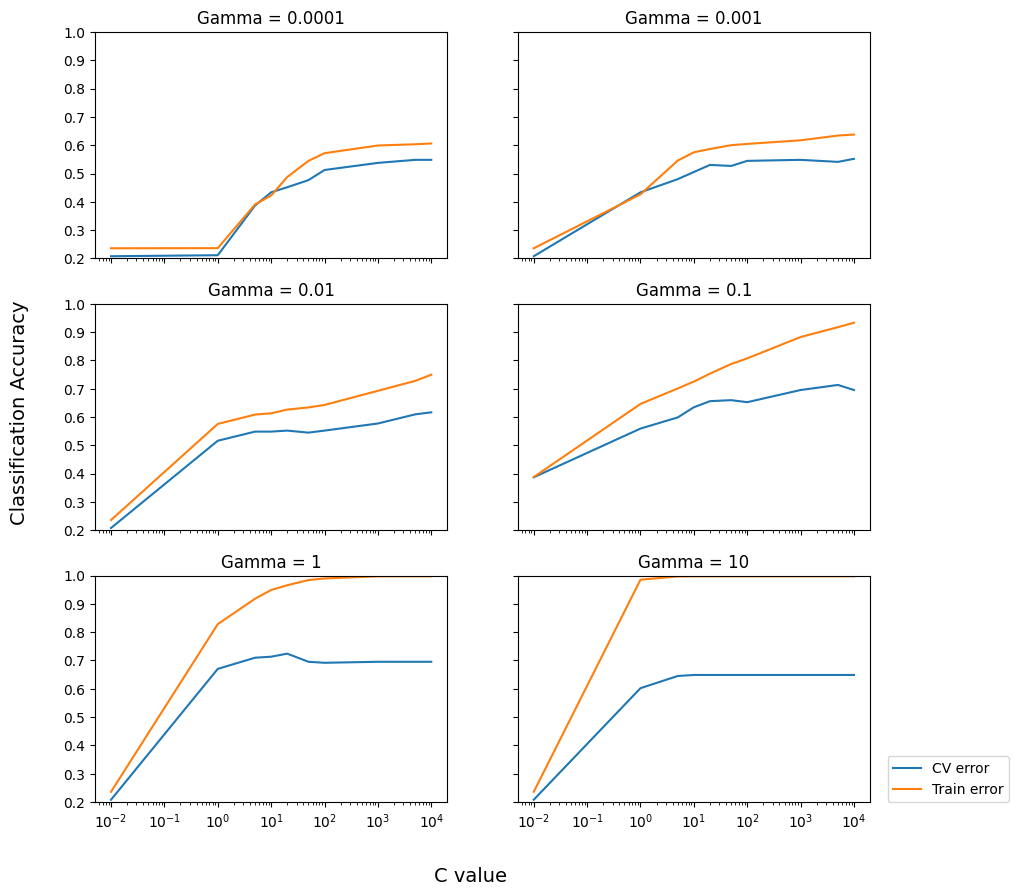

In [27]:
%%time
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

In [37]:
clf = svm.SVC(C=10, gamma=1)
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.71
Optimized adjacent facies classification accuracy = 0.93


In [38]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18     5     1                                        24
     CSiS     1    48     9                                        58
     FSiS     1    13    25           1                            40
     SiSh           1     1    12           1           1          16
       MS           1           2    14    10           3          30
       WS                       3     4    23     1     4          35
        D                       1     2           8                11
       PS                             2     9          40          51
       BS                                               3    11    14

Precision  0.90  0.71  0.69  0.67  0.61  0.53  0.89  0.78  1.00  0.72
   Recall  0.75  0.83  0.62  0.75  0.47  0.66  0.73  0.78  0.79  0.71
       F1  0.82  0.76  0.66  0.71  0.53  0.59  0.80  0.78  0.88  0.71


In [39]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    23           1                                        24
     CSiS          58                                              58
     FSiS     1          38           1                            40
     SiSh           1     1    12           1           1          16
       MS           1                26                 3          30
       WS                       3          32                      35
        D                       1     2           8                11
       PS                             2                49          51
       BS                                                    14    14

Precision  0.96  0.97  0.95  0.75  0.84  0.97  1.00  0.92  1.00  0.93
   Recall  0.96  1.00  0.95  0.75  0.87  0.91  0.73  0.96  1.00  0.93
       F1  0.96  0.98  0.95  0.75  0.85  0.94  0.84  0.94  1.00  0.93


In [40]:
# applying the classification in the blind data
blind.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
476,2,A1 SH,SHANKLE,2777.0,82.56,0.599,12.9,13.105,3.5,1,0.919
477,2,A1 SH,SHANKLE,2777.5,83.12,0.611,13.2,14.000,3.3,1,0.903
478,2,A1 SH,SHANKLE,2778.0,84.26,0.620,12.8,13.685,3.3,1,0.887
479,2,A1 SH,SHANKLE,2778.5,86.29,0.627,13.2,13.920,3.2,1,0.871
480,2,A1 SH,SHANKLE,2779.0,80.95,0.629,13.0,13.975,3.2,1,0.855


In [41]:
y_blind = blind['Facies'].values
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

In [50]:
X_blind = transform_data(well_features)

In [52]:
y_pred = clf.predict(X_blind)
blind_svc = blind.copy()
blind_svc['Prediction'] = y_pred

In [53]:
blind_svc['Prediction'].unique()

array([2, 3, 1, 5, 8, 6, 4, 7])

In [57]:
blind_cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(blind_cv_conf))
# print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(blind_cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.42


In [58]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18     5     1                                        24
     CSiS     1    48     9                                        58
     FSiS     1    13    25           1                            40
     SiSh           1     1    12           1           1          16
       MS           1           2    14    10           3          30
       WS                       3     4    23     1     4          35
        D                       1     2           8                11
       PS                             2     9          40          51
       BS                                               3    11    14

Precision  0.90  0.71  0.69  0.67  0.61  0.53  0.89  0.78  1.00  0.72
   Recall  0.75  0.83  0.62  0.75  0.47  0.66  0.73  0.78  0.79  0.71
       F1  0.82  0.76  0.66  0.71  0.53  0.59  0.80  0.78  0.88  0.71


In [59]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    23           1                                        24
     CSiS          58                                              58
     FSiS     1          38           1                            40
     SiSh           1     1    12           1           1          16
       MS           1                26                 3          30
       WS                       3          32                      35
        D                       1     2           8                11
       PS                             2                49          51
       BS                                                    14    14

Precision  0.96  0.97  0.95  0.75  0.84  0.97  1.00  0.92  1.00  0.93
   Recall  0.96  1.00  0.95  0.75  0.87  0.91  0.73  0.96  1.00  0.93
       F1  0.96  0.98  0.95  0.75  0.85  0.94  0.84  0.94  1.00  0.93


In [60]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

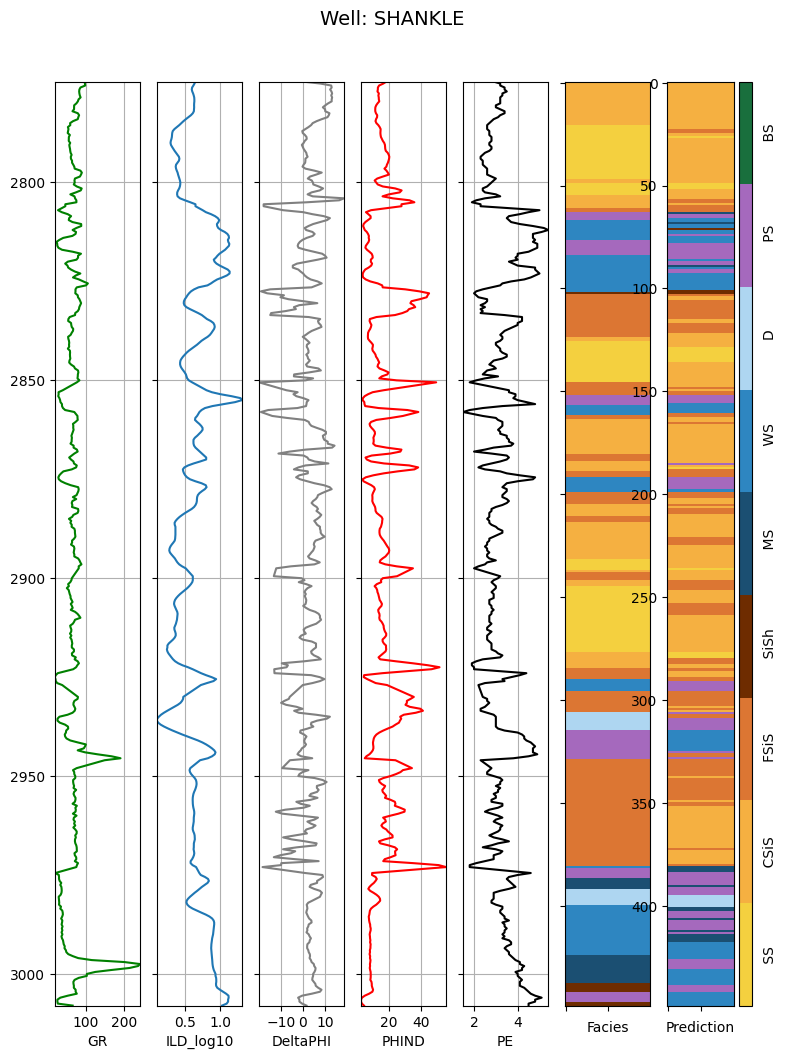

In [61]:
# comparison between results and blind
compare_facies_plot(blind_svc, 'Prediction', facies_colors)

In [62]:
# applying on the training dataset
validation_url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv'
well_data = pd.read_csv(validation_url)
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

In [63]:
X_unknown = transform_data(well_features)

In [64]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [65]:
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

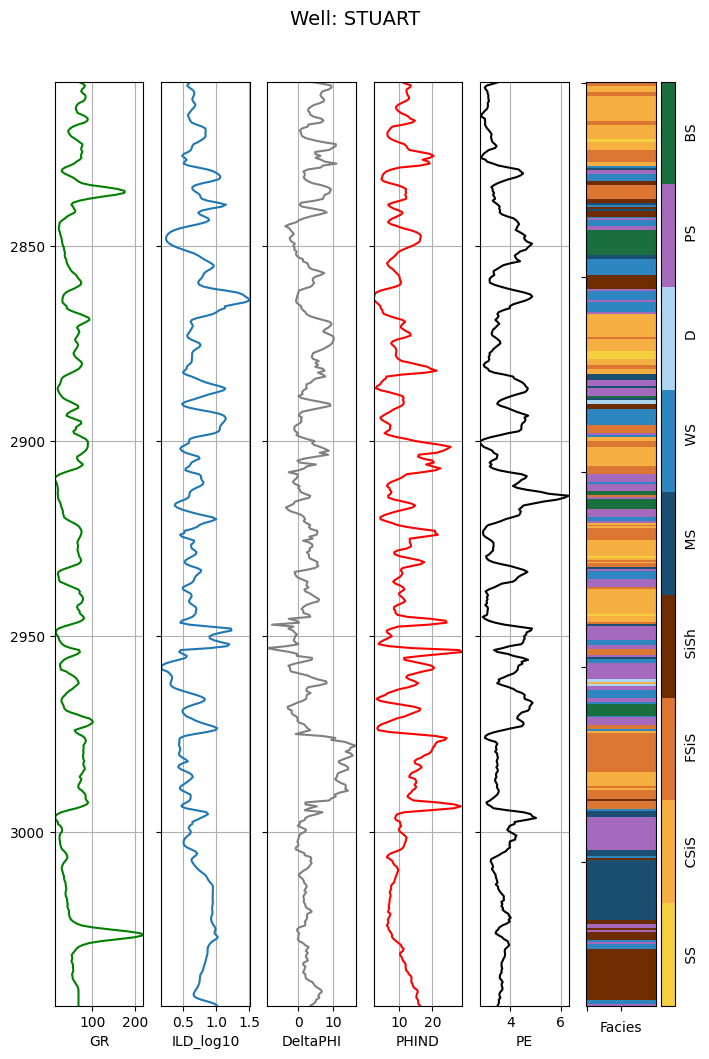

In [66]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

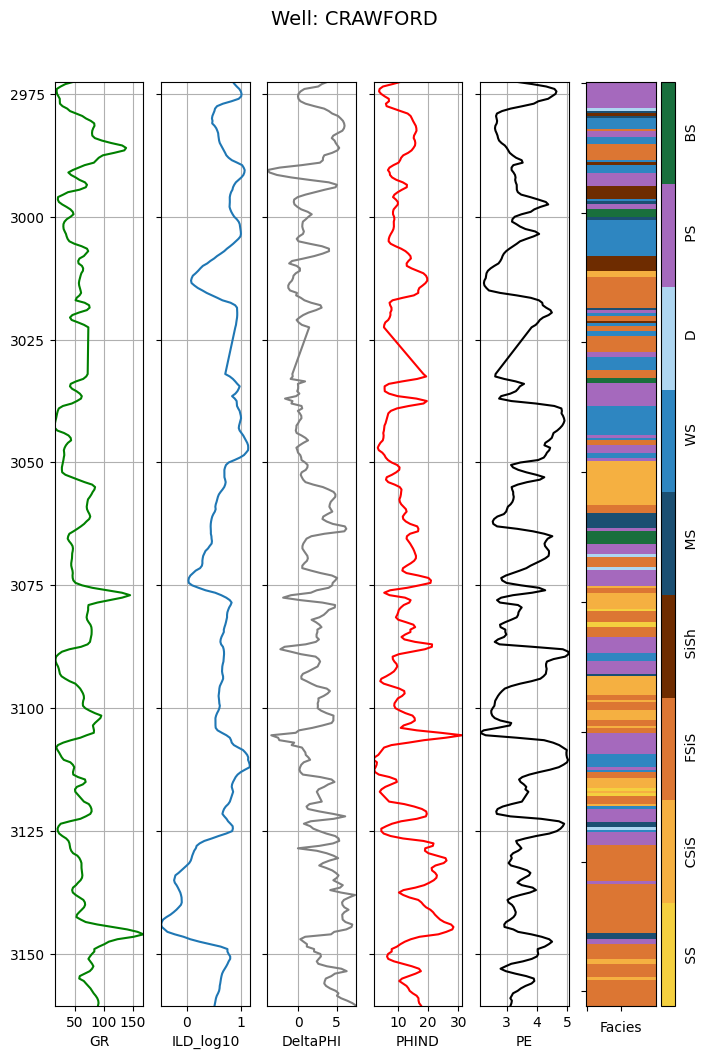

In [67]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

## CatBoost classifier

This section will follow my solution to the problem...

Can CatBoost beat the winner metric?

In [68]:
# %%capture
# !pip install catboost

In [69]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [70]:
# definning a training pool and parameters
params = {
    'iterations': 1000,
    'learning_rate': 0.5,
    'eval_metric': metrics.Accuracy(),
#     'custom_loss': [metrics.Accuracy()],
#     'loss_function': metrics.MultiClass(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'task_type': 'GPU',
    'use_best_model': True, 
    'depth': 6
}
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

In [71]:
cbt = CatBoostClassifier(**params)
cbt.fit(train_pool, eval_set=validate_pool)

In [72]:
%%time
# cross validation
cv_params = {
    'iterations': 1000,
    'learning_rate': 0.5,
    'eval_metric': metrics.Accuracy(),
    'loss_function': metrics.MultiClass(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True, 
    'depth': 6,
}

cv_data = cv(
    Pool(scaled_features, correct_facies_labels),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1min 57s, sys: 21.5 s, total: 2min 18s
Wall time: 30.7 s


In [73]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Best validation accuracy score: 0.73±0.01 on step 773
Precise validation accuracy score: 0.7269222601355527


In [74]:
feature_importances = cbt.get_feature_importance(train_pool)
feature_names = feature_vectors.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

GR: 17.029594961606833
RELPOS: 16.41740486036249
PHIND: 14.568269740275367
ILD_log10: 13.896713797516094
DeltaPHI: 13.505645805665646
PE: 13.484513958941555
NM_M: 11.097856875632017


In [75]:
eval_metrics = cbt.eval_metrics(validate_pool, [metrics.Accuracy(), metrics.F1()], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [76]:
#how it looks
print(eval_metrics['Accuracy'][:6])

[0.5053763440860215, 0.5125448028673835, 0.5412186379928315, 0.5627240143369175, 0.5949820788530465, 0.5842293906810035]


In [83]:
import hyperopt

def hyperopt_objective(params):
    model_params = {
        'iterations': 500,
        'eval_metric': metrics.Accuracy(),
        'loss_function': metrics.MultiClass(),
        'random_seed': 42,
        'logging_level': 'Silent',
#         'task_type': 'GPU',
#         'verbose':False,
        'depth': 6
    }
    
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
#         task_type="GPU",
        **model_params
    )
    
    cv_data = cv(
#         Pool(X_train, y_train),
        Pool(scaled_features, correct_facies_labels),
        model.get_params(),
        logging_level='Silent',
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [84]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(123)
)

print(best)

100%|█████████████████████████████████████████████████| 30/30 [07:16<00:00, 14.55s/trial, best loss: 0.2676634198158113]
{'l2_leaf_reg': 1.0, 'learning_rate': 0.2487239767768938}


In [85]:
best['learning_rate']

0.2487239767768938

In [86]:
model_params = {
    'iterations': 500,
    'eval_metric': metrics.Accuracy(),
    'loss_function': metrics.MultiClass(),
    'random_seed': 42,
    'logging_level': 'Silent',
#     'task_type': 'GPU',
    'depth': 6
}
cbt = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    task_type = 'GPU',
    **model_params
)
cbt.fit(train_pool, eval_set=validate_pool,
        verbose=False,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
print('CatBoost model is fitted: ' + str(cbt.is_fitted()))
print('CatBoost model parameters:')
print(cbt.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 500, 'learning_rate': 0.2487239767768938, 'depth': 6, 'l2_leaf_reg': 1, 'loss_function': 'MultiClass', 'random_seed': 42, 'logging_level': 'Silent', 'eval_metric': 'Accuracy', 'task_type': 'GPU'}


In [88]:
predicted_labels_CBC = cbt.predict(X_test)

In [89]:
conf_CBC = confusion_matrix(y_test, predicted_labels_CBC)

In [90]:
display_cm(conf_CBC, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    19     4     1                                        24
     CSiS          49     9                                        58
     FSiS     1    11    28                                        40
     SiSh           1          14           1                      16
       MS                 1     2     8    15           4          30
       WS                       1     2    27           5          35
        D                             2           9                11
       PS                             5     7          38     1    51
       BS                                               3    11    14


In [91]:
print('Facies classification accuracy CB = %f' % accuracy(conf_CBC))
print('Adjacent facies classification accuracy CB = %f' % accuracy_adjacent(conf_CBC, adjacent_facies))

Facies classification accuracy CB = 0.727599
Adjacent facies classification accuracy CB = 0.939068


In [92]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.569892
Adjacent facies classification accuracy = 0.924731


In [108]:
y_pred_cb = cbt.predict(X_blind)
blind_cb = blind.copy()
blind_cb['Prediction'] = y_pred_cb

In [109]:
cv_conf_CBC = confusion_matrix(y_blind, y_pred_cb)

In [110]:
display_cm(cv_conf_CBC, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    19    68     2                                        89
     CSiS     4    71    13                             1          89
     FSiS          52    60           3                 2         117
     SiSh                       1           5           1           7
       MS                       1          13           5          19
       WS                 2     1     9    34          25          71
        D                                   1    11     5          17
       PS                       1           7          29     3    40
       BS                                                           0

Precision  0.83  0.37  0.78  0.25  0.00  0.57  1.00  0.43  0.00  0.61
   Recall  0.21  0.80  0.51  0.14  0.00  0.48  0.65  0.72  0.00  0.50
       F1  0.34  0.51  0.62  0.18  0.00  0.52  0.79  0.54  0.00  0.49


/home/juanxo90/Dev/facies_classification/classification_utilities.py:14: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
/home/juanxo90/Dev/facies_classification/classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [111]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18     5     1                                        24
     CSiS     1    48     9                                        58
     FSiS     1    13    25           1                            40
     SiSh           1     1    12           1           1          16
       MS           1           2    14    10           3          30
       WS                       3     4    23     1     4          35
        D                       1     2           8                11
       PS                             2     9          40          51
       BS                                               3    11    14

Precision  0.90  0.71  0.69  0.67  0.61  0.53  0.89  0.78  1.00  0.72
   Recall  0.75  0.83  0.62  0.75  0.47  0.66  0.73  0.78  0.79  0.71
       F1  0.82  0.76  0.66  0.71  0.53  0.59  0.80  0.78  0.88  0.71


In [112]:
print('Facies classification accuracy CBC = %.2f' % accuracy(cv_conf_CBC))
print('Adjacent facies classification accuracy CBC = %.2f' % accuracy_adjacent(cv_conf_CBC, adjacent_facies))

Facies classification accuracy CBC = 0.50
Adjacent facies classification accuracy CBC = 0.95


In [113]:
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.71
Optimized adjacent facies classification accuracy = 0.93


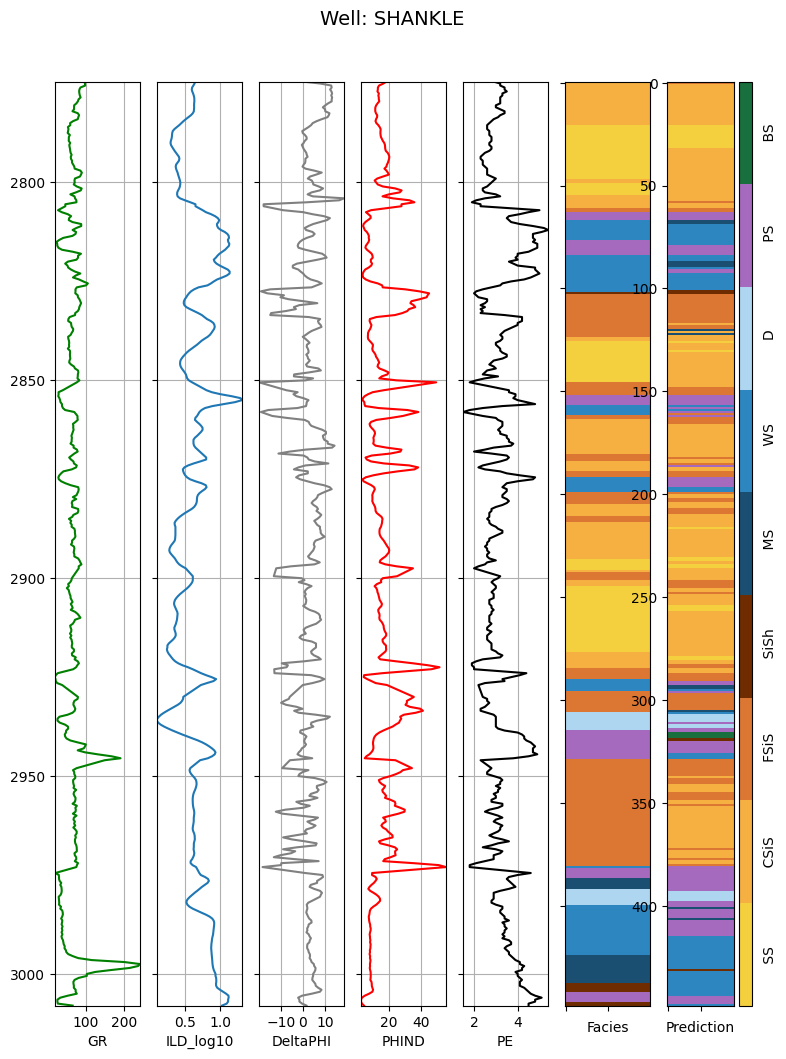

In [114]:
compare_facies_plot(blind_cb, 'Prediction', facies_colors)

In [115]:
# applying on the no facies
validation_url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv'
well_data_cb = pd.read_csv(validation_url)
well_data_cb['Well Name'] = well_data_cb['Well Name'].astype('category')
well_features_cb = well_data_cb.drop(['Formation', 'Well Name', 'Depth'], axis=1)

In [116]:
X_unknown_cb = transform_data(well_features_cb)

In [117]:
#predict facies of unclassified data
y_unknown_cb = cbt.predict(X_unknown_cb)
well_data_cb['Facies'] = y_unknown_cb
well_data_cb.head(10)

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,2
5,A1 SH,STUART,2810.5,73.955,0.667,6.9,12.25,3.086,1,0.889,2
6,A1 SH,STUART,2811.0,77.962,0.674,6.5,12.45,3.092,1,0.867,2
7,A1 SH,STUART,2811.5,83.894,0.667,6.3,12.65,3.123,1,0.844,2
8,A1 SH,STUART,2812.0,84.424,0.653,6.7,13.05,3.121,1,0.822,2
9,A1 SH,STUART,2812.5,83.160,0.642,7.3,12.95,3.127,1,0.800,2


In [118]:
well_data_cb['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

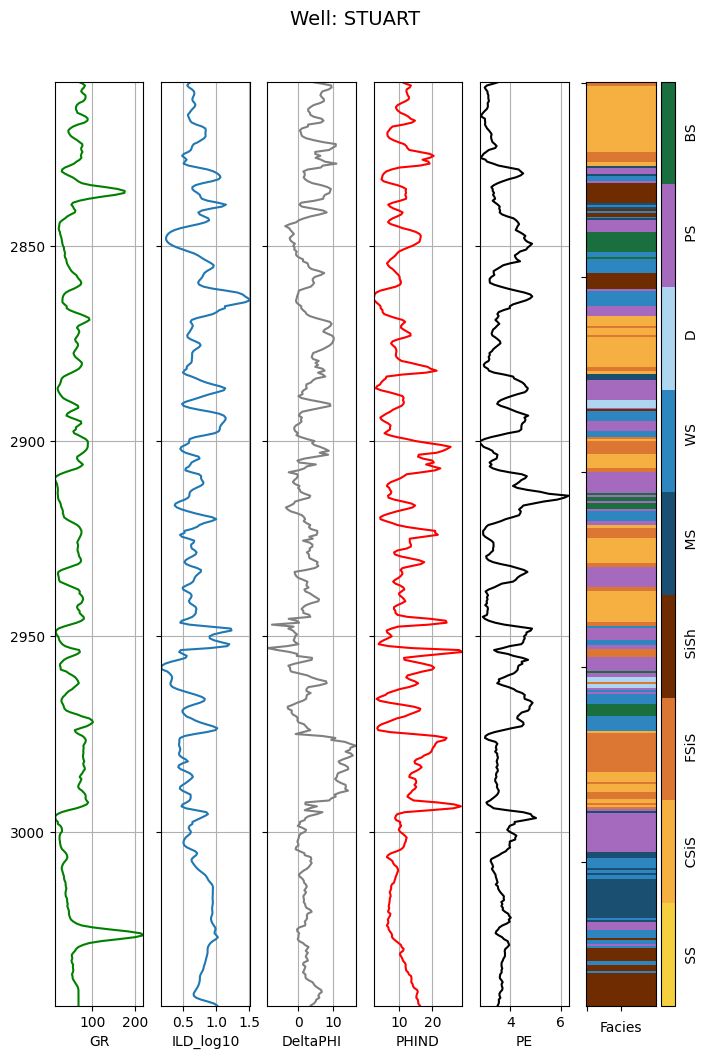

In [119]:
make_facies_log_plot(
    well_data_cb[well_data_cb['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

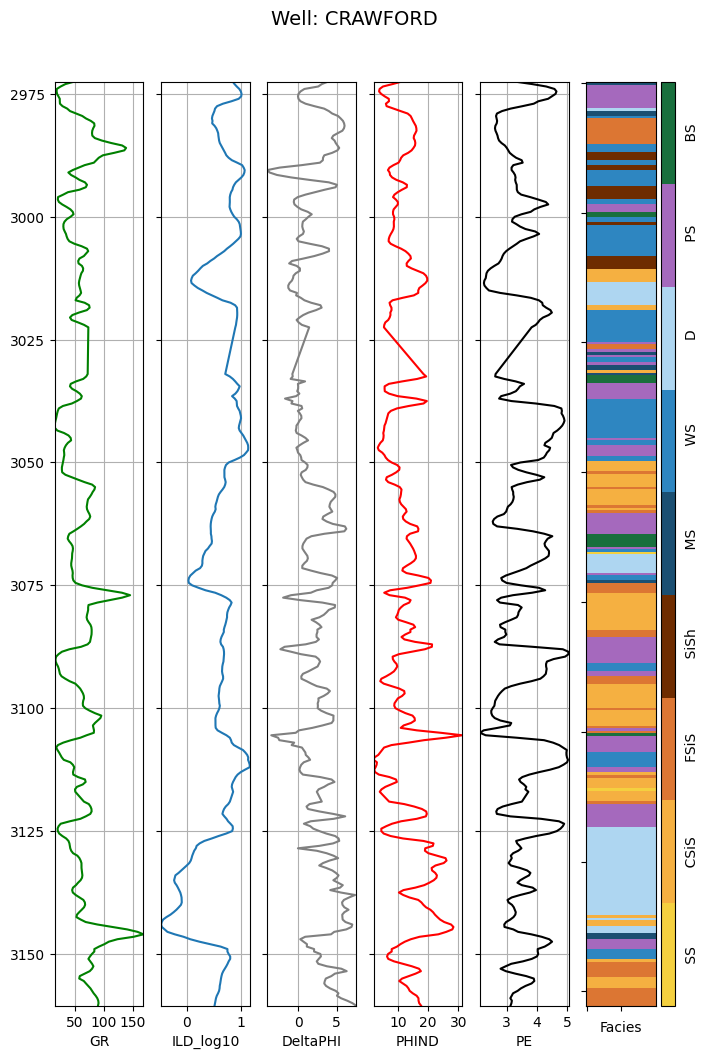

In [120]:
make_facies_log_plot(
    well_data_cb[well_data_cb['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

## Model validation

To score the calssification, 100 realization of the models.

In [141]:
well_data_val = pd.read_csv(validation_url)
well_data_val['Well Name'] = well_data_val['Well Name'].astype('category')
well_data_val = well_data_val.drop(['Formation', 'Well Name', 'Depth'], axis=1)
X_unknown = transform_data(well_features)

In [142]:
from tqdm import tqdm

In [143]:
y_preds = []

for seed in tqdm(range(100)):
    
    model_params = {
        'iterations': 600,
        'eval_metric': metrics.Accuracy(),
        'loss_function': metrics.MultiClass(),
        'random_seed': seed,
        'logging_level': 'Silent',
    #     'task_type': 'GPU',
        'depth': 6,
        'use_best_model': True, 
    }
    
    cbt = CatBoostClassifier(
        l2_leaf_reg=int(best['l2_leaf_reg']),
        learning_rate=best['learning_rate'],
        task_type = 'GPU',
        **model_params
    )
    
    cbt.fit(train_pool, eval_set=validate_pool,
            verbose=False,
            plot=False)
    
    y_pred_val = cbt.predict(X_unknown)
    y_preds.append(y_pred_val)    


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [15:07<00:00,  9.07s/it]


In [144]:
url_pred = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/prediction_depths.csv'
PRED = pd.read_csv(url_pred)
PRED.set_index(["Well Name", "Depth"], inplace=True)
PRED.head()

Unnamed: 0
Well Name Depth             
STUART    2808.0           0
          2808.5           1
          2809.0           2
          2809.5           3
          2810.0           4

In [145]:
url_true = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/blind_stuart_crawford_core_facies.csv'
TRUE = pd.read_csv(url_true)
TRUE.rename(columns={'Depth.ft': 'Depth'}, inplace=True)
TRUE.rename(columns={'WellName': 'Well Name'}, inplace=True)
TRUE.set_index(["Well Name", "Depth"], inplace=True)
TRUE.head()

LithCode     LithLabel
Well Name Depth                         
STUART    2807.5         3  NM Shly Silt
          2808.0         3  NM Shly Silt
          2808.5         3  NM Shly Silt
          2809.0         3  NM Shly Silt
          2809.5         3  NM Shly Silt

In [146]:
def get_accuracies(y_preds):
    """
    Get the F1 scores from all the y_preds.
    y_blind is a 1D array. y_preds is a 2D array.
    """
    accs = []
    for y_pred in y_preds:
        PRED['Facies'] = y_pred
        all_data = PRED.join(TRUE, how='inner')
        y_blind = all_data['LithCode'].values
        y_pred = all_data['Facies'].values
        y_pred = y_pred[y_blind!=11]
        y_blind = y_blind[y_blind!=11]
        cv_conf = confusion_matrix(y_blind, y_pred)
        accs.append(accuracy(cv_conf))
    return np.array(accs)

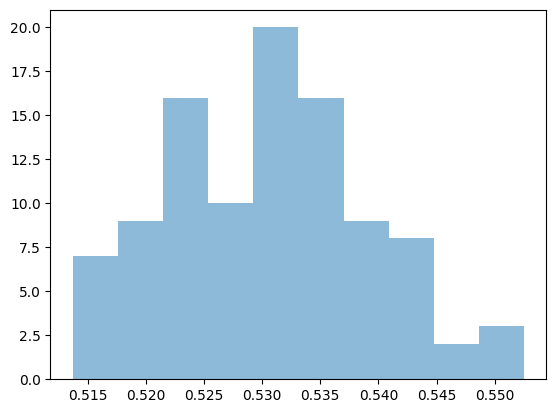

In [149]:
scores = get_accuracies(y_preds)
medians = np.median(scores)
plt.hist(pd.Series(scores), alpha=0.5);

In [150]:
medians

0.530625

In [148]:
s = pd.Series(scores)
s.describe()

count    100.000000
mean       0.530575
std        0.008593
min        0.513750
25%        0.523750
50%        0.530625
75%        0.535313
max        0.552500
dtype: float64